In [38]:
import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [39]:
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import sys
import os

xtree = et.parse("/content/drive/MyDrive/Rick- Anomaly Detection/Data/SUMO/sumoTrace_v4.xml")
xroot = xtree.getroot()

In [40]:
# Initialize empty lists to store data
data = {
    'time': [],
    'vehicle_id': [],
    'x': [],
    'y': [],

    'speed': [],
    'pos': [],

}


In [41]:
# Iterate over timestep elements and extract data
for timestep in xroot.findall('timestep'):
    time = float(timestep.get('time'))
    for vehicle in timestep.findall('vehicle'):
        vehicle_id = int(vehicle.get('id'))
        x = float(vehicle.get('x'))
        y = float(vehicle.get('y'))

        speed = float(vehicle.get('speed'))
        pos = float(vehicle.get('pos'))


        # Append data to respective lists
        data['time'].append(time)
        data['vehicle_id'].append(vehicle_id)
        data['x'].append(x)
        data['y'].append(y)

        data['speed'].append(speed)
        data['pos'].append(pos)


# Create DataFrame from the collected data
data = pd.DataFrame(data)

# Print the resulting DataFrame
print(data)

         time  vehicle_id        x        y  speed    pos
0         0.0           0  3669.96  4203.11   0.00   5.10
1         0.5           0  3669.42  4203.09   1.07   5.63
2         1.0           0  3668.30  4203.03   2.26   6.76
3         1.5           0  3666.52  4202.94   3.55   8.54
4         2.0           0  3664.15  4202.82   4.76  10.92
...       ...         ...      ...      ...    ...    ...
113483  788.0         179  2267.78   988.21  15.76   8.63
113484  788.5         179  2266.92   996.10  15.88  16.57
113485  789.0         179  2266.06  1003.98  15.83   6.64
113486  789.5         179  2265.21  1011.73  15.60   5.04
113487  790.0         179  2264.34  1019.69  16.02  13.05

[113488 rows x 6 columns]


In [93]:
# Change id here for different paths from SUMO
id = 10

df_x0 = data[data['vehicle_id'] == id]

In [186]:

def extreme_random_interpolation(point1, point2, num_points):
    # Calculate the step size for interpolation
    step = 1.0 / (num_points - 1)

    # Initialize the result list with the first point
    interpolated_points = [point1]

    # Perform extreme random interpolation
    for i in range(1, num_points - 1):
        # Generate a random number between -1 and 1
        randomness = np.random.uniform(-1, 1)

        # Calculate the interpolated value with added randomness
        interpolated_value = point1 + (point2 - point1) * step * i + randomness

        # Append the interpolated value to the result list
        interpolated_points.append(interpolated_value)

    # Append the second point to complete the interpolation
    interpolated_points.append(point2)

    return interpolated_points

def create_sensor_data(num_noise_columns = 40, std = .01, num_attacked = 2, data = df_x0):
  # Create Unattacked data
  # Create new columns with Gaussian noise added to 'x'
  df_un = data[['time', 'vehicle_id', 'x']]

  for i in range(num_noise_columns):
      column_name = f'x_{i + 1}'
      noise = np.random.normal(0, std, size=len(df_un))
      df_un[column_name] = df_un['x'] + noise

  # df_unattacked = df_un.drop(columns=['x', 'time', 'vehicle_id'])
  df_unattacked = df_un.drop(columns=['time', 'vehicle_id'])

  # Create attacked data
  # df_x = df_un.drop(columns=['x', 'time', 'vehicle_id'])
  df_x = df_un.drop(columns=['time', 'vehicle_id'])
  df_x = df_x.reset_index()
  df_x = df_x.drop(columns = ['index'])
  # Create new columns with Gaussian noise added to 'x' (with consecutive missing values)
  for i in range((num_noise_columns-num_attacked), df_unattacked.shape[1]):
      # Introduce consecutive missing values in the new column
      missing_start = np.random.choice(range(10, len(df_x)))
      missing_end = np.random.choice(range(missing_start, len(df_x)))
      if missing_end- missing_start <= 1:
        missing_end = missing_start + 4
      df_x.loc[missing_start:missing_end, f'x_{i}'] = np.nan


  for column in df_x.columns:
    # df_x[column] = fill_consecutive_nans_with_interpolation(df_x[column])
    if df_x[column].isna().any() == True:
      nan_indices = df_x[df_x[column].isna()].index
      first_index = min(nan_indices)
      last_index = max(nan_indices)

      first_value = df_x.loc[first_index-1, column]
      if last_index == len(df_x)-1:
        last_value = df_x.loc[last_index, column]
      elif last_index < len(df_x)-1:
        last_value = df_x.loc[last_index+1, column]
      num_points = last_index - first_index + 1
      interpolated = extreme_random_interpolation(first_value, last_value, num_points)

      df_x.loc[first_index:last_index, column] = interpolated



  return df_un, df_unattacked, df_x

#### testing the create sensor function

In [185]:
df_un, df_unattacked, df_x = create_sensor_data(num_attacked=20, data=df_x0)

<ipython-input-171-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-171-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise


In [8]:
df_x.head()

,x,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40
0,1204.82,1204.817596,1204.820812,1204.815701,1204.820652,1204.826074,1204.829190,1204.819507,1204.827810,1204.817630,...,1204.820221,1204.819450,1204.805000,1204.813688,1204.804255,1204.818587,1204.825118,1204.830717,1204.820362,1204.816188
1,1204.83,1204.824677,1204.817605,1204.826433,1204.817172,1204.820559,1204.829458,1204.828623,1204.835445,1204.839685,...,1204.813041,1204.828816,1204.832412,1204.828535,1204.820037,1204.825039,1204.827146,1204.837542,1204.843365,1204.827444
2,1204.85,1204.856034,1204.845709,1204.857840,1204.862595,1204.861599,1204.846011,1204.835983,1204.855854,1204.866332,...,1204.861376,1204.854864,1204.858872,1204.860157,1204.856425,1204.853578,1204.853842,1204.848004,1204.867426,1204.845543
3,1204.88,1204.878629,1204.888380,1204.878807,1204.885643,1204.870614,1204.872932,1204.886603,1204.879773,1204.868603,...,1204.872236,1204.892415,1204.881014,1204.881915,1204.872874,1204.886237,1204.878923,1204.887549,1204.881432,1204.885426
4,1204.92,1204.912221,1204.910365,1204.929121,1204.914616,1204.923936,1204.926647,1204.926860,1204.925202,1204.911430,...,1204.909829,1204.925279,1204.921447,1204.919279,1204.931489,1204.908314,1204.923154,1204.922392,1204.918378,1204.920454


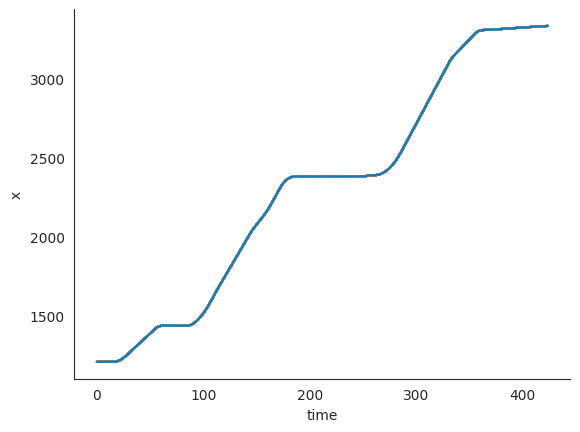

In [9]:
# Plot each noise column
for column in df_unattacked.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  plt.plot(range(0, len(df_unattacked)), df_unattacked[column], label=column)

# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

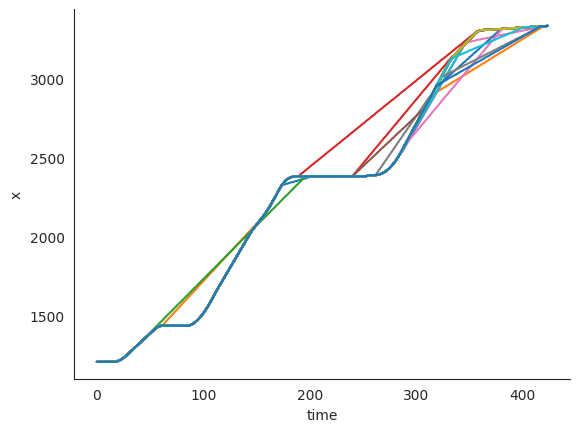

In [10]:
# Plot each noise column
for column in df_x.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  plt.plot(range(0, len(df_x)), df_x[column], label=column)

# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

In [11]:
# To identify attacked sensors
def get_difference_and_remove_margin_value_training(sensor_training, sensor_testing, percentile=95):
    difference_training = []
    difference_testing = []
    for i in range(len(sensor_training) - 1):
        difference1 = (sensor_training[i + 1] - sensor_training[0])/sensor_training[0]
        difference_training.append(difference1)
    difference_training = np.array(difference_training)

    for i in range(len(sensor_testing) - 1):
        difference2 = (sensor_testing[i + 1] - sensor_testing[0])/sensor_testing[0]
        difference_testing.append(difference2)
    difference_testing = np.array(difference_testing)

    # Compute the 95% quantile of difference_training
    # percentile = percentile
    d2 = np.percentile(difference_training, 100 - (100-percentile)/2)
    d1 = np.percentile(difference_training, 0+(100-percentile)/2)
    # Filter out values in difference_testing that fall within [-d, d]
    mask = np.logical_and(difference_testing >= d1, difference_testing <= d2)
    Difference_after_remove = difference_testing[mask]

    # Obtain the indices of the remaining values
    indices_after_remove = np.where(mask)[0]

    return Difference_after_remove, indices_after_remove

#### Train the SAITs for missing value imputation

In [12]:
pip install pypots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 3.0 MB/s eta 0:00:00


In [13]:
# Install PyPOTS first: pip install pypots==0.1.1
import numpy as np
from sklearn.preprocessing import StandardScaler
from pypots.data import load_specific_dataset, mcar, masked_fill
from pypots.imputation import SAITS
from pypots.utils.metrics import cal_mae


In [14]:
# Data preprocessing. Tedious, but PyPOTS can help.
# data = load_specific_dataset('physionet_2012')  # For datasets in PyPOTS database, PyPOTS will automatically download and extract it.
X = df_unattacked[:10000].to_numpy()

timesteps = 1
features = len(df_unattacked.columns)

number_of_samples = X.shape[0] // timesteps

X = X[:number_of_samples * timesteps, :].reshape(number_of_samples, timesteps, features)

X_intact, X, missing_mask, indicating_mask = mcar(X, 0.20) # hold out 10% observed values as ground truth
X = masked_fill(X, 1 - missing_mask, np.nan)

In [15]:
# Model training. This is PyPOTS showtime.
saits = SAITS(n_steps=timesteps, n_features=features, n_layers=2, d_model=256, d_inner=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=2000)
dataset = {"X": X}
saits.fit(dataset)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
mae = cal_mae(imputation, X_intact, indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

2023-08-08 16:15:46 [INFO]: No given device, using default device: cpu
2023-08-08 16:15:46 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2023-08-08 16:15:46 [INFO]: Model initialized successfully with the number of trainable parameters: 1,383,407
2023-08-08 16:15:48 [INFO]: epoch 0: training loss 2787.5876
2023-08-08 16:15:49 [INFO]: epoch 1: training loss 970.4139
2023-08-08 16:15:50 [INFO]: epoch 2: training loss 528.6087
2023-08-08 16:15:51 [INFO]: epoch 3: training loss 378.6794
2023-08-08 16:15:52 [INFO]: epoch 4: training loss 330.1700
2023-08-08 16:15:53 [INFO]: epoch 5: training loss 290.7546
2023-08-08 16:15:54 [INFO]: epoch 6: training loss 257.1273
2023-08-08 16:15:55 [INFO]: epoch 7: training loss 249.8051
2023-08-08 16:15:55 [INFO]: epoch 8: training loss 248.7677
2023-08-08 16:15:56 [INFO]: epoch 9: training loss 240.9270
2023-08-08 16:15:56 [INFO]: epoch 10: training loss 232.9928
2023-08-08 16:15:57 [INFO]: epoch 11: training loss 22

In [16]:
# FSPM (Fusion ) model

def partition_dataset(sequence_length, data):
    data = StandardScaler().fit_transform(data)
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, 0]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(20, df_unattacked)

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Training the model
epochs = 500
batch_size = 64
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[early_stop]
                   )

                    #callbacks=[early_stop])

820 20 41
Epoch 1/500
6/6 [==============================] - 16s 2s/step - loss: 9.8849 - val_loss: 1.9616
Epoch 2/500
6/6 [==============================] - 11s 2s/step - loss: 0.3201 - val_loss: 0.4575
Epoch 3/500
6/6 [==============================] - 11s 2s/step - loss: 0.0753 - val_loss: 0.2865
Epoch 4/500
6/6 [==============================] - 11s 2s/step - loss: 0.0338 - val_loss: 0.1402
Epoch 5/500
6/6 [==============================] - 10s 2s/step - loss: 0.0335 - val_loss: 0.0038
Epoch 6/500
6/6 [==============================] - 11s 2s/step - loss: 0.0114 - val_loss: 0.0278
Epoch 7/500
6/6 [==============================] - 11s 2s/step - loss: 0.0063 - val_loss: 0.0114
Epoch 8/500
6/6 [==============================] - 11s 2s/step - loss: 0.0065 - val_loss: 9.6252e-04
Epoch 9/500
6/6 [==============================] - 11s 2s/step - loss: 0.0027 - val_loss: 0.0011
Epoch 10/500
6/6 [==============================] - 10s 2s/step - loss: 0.0016 - val_loss: 0.0024
Epoch 11/500
6/

In [22]:
df = df_x.copy(deep=True)
  # df = df.drop(columns = ['time'])
for i in range(1, len(df)+1):


  timestep = df[i-1:i]

  old_stdout = sys.stdout # backup current stdout
  sys.stdout = open(os.devnull, "w")
  # label_attack = get_difference_and_remove_margin_value(np.array(df[i-1:i]).flatten(), percentile_level = 0.95)[1]
  label_attack = get_difference_and_remove_margin_value_training(np.array(df_unattacked[0:1]).flatten(), np.array(df[i-1:i]).flatten(), 90)[1]
  label_attack_95 = list(map(lambda l : l + 1, label_attack))

  # label_attack = find_attacked_sensor(np.array(df[1:2]).flatten(), np.array(df[i:i+1]).flatten(), np.array(df[1:2]).flatten()[0], mean=0, std=0.1, sample_size1=7, sample_size2=7, percentile_level=0.95)[2]
  # label_attack = label_attack + label_attack_95
  sys.stdout = old_stdout # reset old stdout
  m = list(set(range(1,40)).difference(label_attack_95))

  df[i-1:i].iloc[:, m] = np.nan

  # Imputing Nan with SAITs
  if i % timesteps == 0 :
    X = df[i-timesteps:i].to_numpy()

    X = X[:1 * timesteps, :].reshape(1, timesteps, features)

    dataset = {"X": X}
    imputation = saits.impute(dataset)

    df[i-timesteps:i] = pd.DataFrame(imputation.reshape(-1, X.shape[-1]))



<ipython-input-22-308062085277>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i-1:i].iloc[:, m] = np.nan


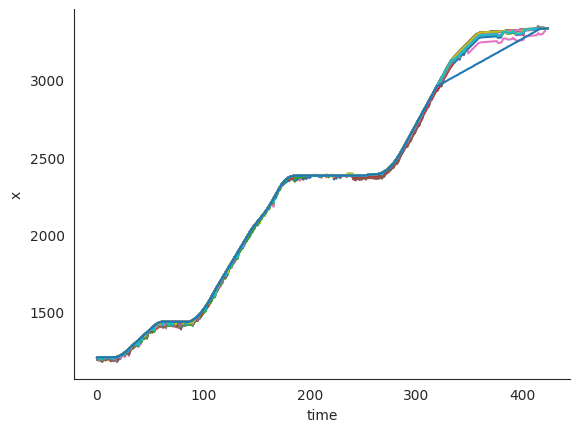

In [23]:
# Plot each noise column
for column in df.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  plt.plot(range(0, len(df)), df[column], label=column)

# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

In [25]:
# End to End point prediction

def fspm(data = df_x):

  df = data.copy(deep=True)
  # df = df.drop(columns = ['time'])
  for i in range(1, len(df)+1):


    timestep = df[i-1:i]

    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    # label_attack = get_difference_and_remove_margin_value(np.array(df[i-1:i]).flatten(), percentile_level = 0.95)[1]
    label_attack = get_difference_and_remove_margin_value_training(np.array(df_unattacked[0:1]).flatten(), np.array(df[i-1:i]).flatten(), 95)[1]
    label_attack_95 = list(map(lambda l : l + 1, label_attack))

    # label_attack = find_attacked_sensor(np.array(df[1:2]).flatten(), np.array(df[i:i+1]).flatten(), np.array(df[1:2]).flatten()[0], mean=0, std=0.1, sample_size1=7, sample_size2=7, percentile_level=0.95)[2]
    # label_attack = label_attack + label_attack_95
    sys.stdout = old_stdout # reset old stdout
    m = list(set(range(1,40)).difference(label_attack_95))

    df[i-1:i].iloc[:, m] = np.nan

    # df_after_attack_iden = df.copy(deep=True)

    # Imputing Nan with SAITs
    if i % timesteps == 0 :
      X = df[i-timesteps:i].to_numpy()

      X = X[:1 * timesteps, :].reshape(1, timesteps, features)

      dataset = {"X": X}
      imputation = saits.impute(dataset)

      df[i-timesteps:i] = pd.DataFrame(imputation.reshape(-1, X.shape[-1]))

  df_after_missing_value_imp = df.copy(deep=True)

  # Create scaled df for FSPM
  x_test, y_test = partition_dataset(20, df)
  # Make Predictions
  pred = model.predict(x_test)
  # Create the scaler object
  scaler = StandardScaler()
  # Fit the scaler to your original data to compute the mean and standard deviation
  scaler.fit(df)
  pred_reshaped = np.repeat(pred, df.shape[1], axis=1)
  # Use the inverse_transform() method to obtain the original values from the scaled data
  data_original = scaler.inverse_transform(pred_reshaped)

  final_predictions = pd.DataFrame(data_original).iloc[:,0]

  return df_after_missing_value_imp , final_predictions
  # return df

In [26]:
# df_after_attack_iden, df_after_missing_value_imp, final_predictions = fspm(data = df_x)
df_after_missing_value_imp , final_predictions = fspm(data = df_x)

<ipython-input-25-6b857bf310c0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i-1:i].iloc[:, m] = np.nan


13/13 [==============================] - 4s 289ms/step


#### Make multiple estimate for different instances of attacks using a single path

In [27]:
monte_carlo_runs = 10
estimations = pd.DataFrame()

In [28]:
for i in range(1, monte_carlo_runs):
  df_un, df_unattacked, df_x = create_sensor_data()
  df_after_missing_value_imp, final_predictions = fspm(data = df_x)

  estimations = estimations.append(final_predictions)

<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

13/13 [==============================] - 4s 280ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 5s 390ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 6s 455ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 4s 330ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 4s 276ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 6s 457ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 4s 304ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 4s 284ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-6-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithC

13/13 [==============================] - 6s 463ms/step


<ipython-input-28-0ba02c70f7e9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)


In [29]:
predictions = estimations.transpose()

In [30]:
predictions.shape

(405, 9)

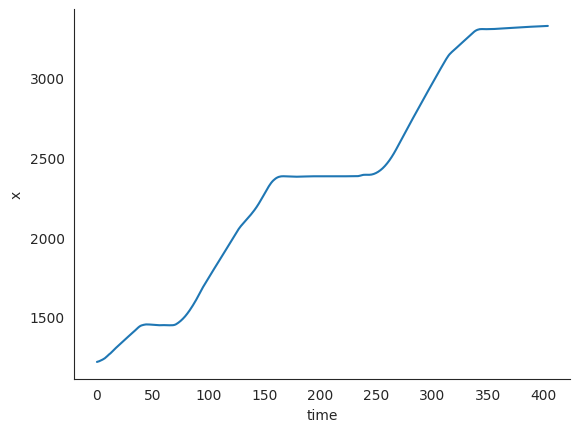

In [31]:
plt.plot(range(0, len(predictions.iloc[:,0])), predictions.iloc[:,0], label=column)
# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

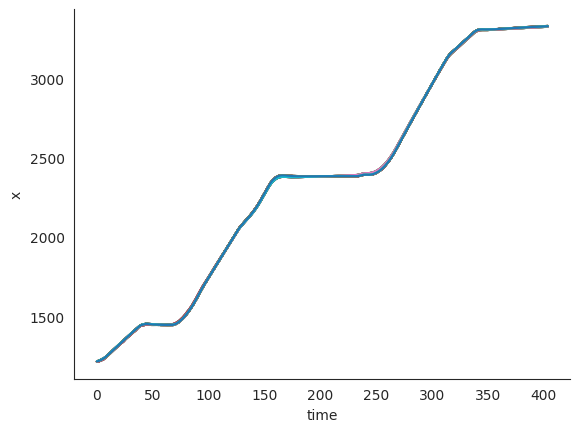

In [32]:
# Plot each noise column
for column in predictions.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  # plt.figure()
  plt.plot(range(0, len(predictions)), predictions[column], label=column)
  # Add labels and legend

plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()


#### Generate predicted paths after missing value imputation and fspm for multiple paths, create 100 estimations for each path

In [48]:
ids = data['vehicle_id'].unique()


In [49]:
ids

array([  0,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  71,  72,  70,  73,  74,  75,  76,  77,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 153, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 19

In [58]:
df_x0

,time,vehicle_id,x,y,speed,pos
5,2.0,2,2905.27,3173.40,0.00,5.10
7,2.5,2,2905.76,3173.66,1.10,5.65
9,3.0,2,2906.69,3174.15,2.11,6.70
12,3.5,2,2908.00,3174.85,2.97,8.19
15,4.0,2,2909.73,3175.77,3.92,10.15
...,...,...,...,...,...,...
46576,228.0,2,4665.08,4420.28,12.85,42.51
46743,228.5,2,4668.90,4425.33,12.67,48.84
46910,229.0,2,4672.78,4430.46,12.86,55.27
47077,229.5,2,4676.65,4435.58,12.85,61.70


In [ ]:
df_un, df_unattacked, df_x = create_sensor_data(num_attacked=20, data=df_x0)

In [ ]:
for z in ids[1:]:
  folder_path = '/content/drive/MyDrive/Rick- Anomaly Detection/Data/SUMO/Results'
  os.makedirs(f'/content/drive/MyDrive/Rick- Anomaly Detection/Data/SUMO/Results/{z}', exist_ok=True)
  df_x0 = df[df['vehicle_id'] == z]

  monte_carlo_runs = 10
  estimations = pd.DataFrame()

  for i in range(1, monte_carlo_runs):
    try:
      df_un, df_unattacked, df_x = create_sensor_data(num_attacked=20, data=df_x0)
    except:
      pass
    df_after_missing_value_imp, final_predictions = fspm(data = df_x)

    estimations = estimations.append(final_predictions)


  for column in predictions.columns:
    # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
    # plt.figure()
    plt.plot(range(0, len(predictions)), predictions[column], label=column)
    # Add labels and legend

  # plt.plot(range(0, len(df_un['x'])), df_un['x'])
  plt.xlabel('time')
  plt.ylabel('x')
  # plt.legend()

  # Show the plot
  plt.savefig(f'/content/drive/MyDrive/Rick- Anomaly Detection/Data/SUMO/Results/{z}_path_pred_est')
  plt.figure()

  for column in df_after_missing_value_imp.columns:
    # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
    # plt.figure()
    plt.plot(range(0, len(df_after_missing_value_imp)), df_after_missing_value_imp[column], label=column)
    # Add labels and legend

  plt.xlabel('time')
  plt.ylabel('x')
  # plt.legend()
  plt.savefig(f'/content/drive/MyDrive/Rick- Anomaly Detection/Data/SUMO/Results/{z}_miss_val_imp')
  plt.figure()




<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

14/14 [==============================] - 10s 668ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 4s 292ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 4s 275ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 6s 436ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 7s 527ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 4s 273ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 5s 315ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 4s 270ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

14/14 [==============================] - 4s 271ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 9s 376ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 9s 378ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 10s 375ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 10s 414ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 9s 394ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 9s 372ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 9s 372ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 9s 376ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 8s 330ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

24/24 [==============================] - 9s 359ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 10s 350ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 12s 394ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 10s 339ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 10s 341ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 10s 312ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 9s 288ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 10s 345ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

30/30 [==============================] - 10s 338ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 5s 317ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 4s 275ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 6s 392ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 4s 269ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 5s 296ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 4s 282ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 4s 271ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 5s 340ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

15/15 [==============================] - 4s 274ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 331ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 8s 299ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 7s 283ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 7s 281ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 7s 280ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 7s 278ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 358ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 354ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 353ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 10s 388ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 353ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 349ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 349ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 360ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 357ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 359ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 359ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 365ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 11s 413ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 10s 347ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 10s 347ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 10s 345ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 10s 344ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 10s 346ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 10s 342ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 9s 310ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

28/28 [==============================] - 8s 282ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 6s 312ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 5s 277ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 7s 354ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 7s 359ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 5s 284ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 5s 278ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 6s 330ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 6s 342ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

19/19 [==============================] - 5s 282ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 4s 424ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 3s 277ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 3s 354ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 3s 272ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 3s 270ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 3s 279ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 3s 272ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 4s 358ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

10/10 [==============================] - 3s 273ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 7s 293ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 11s 428ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 355ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 8s 339ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 8s 315ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 372ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 372ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 360ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 353ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-190-a058d8cb0168>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: Setting

25/25 [==============================] - 9s 354ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

25/25 [==============================] - 9s 353ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

3/3 [==============================] - 1s 231ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

3/3 [==============================] - 1s 228ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

3/3 [==============================] - 1s 235ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

3/3 [==============================] - 1s 242ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

3/3 [==============================] - 1s 437ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

3/3 [==============================] - 1s 265ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

3/3 [==============================] - 1s 237ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 3s 292ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 4s 496ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 3s 295ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 4s 503ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 3s 293ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 4s 490ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 3s 296ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 4s 501ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

9/9 [==============================] - 3s 287ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 5s 416ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 6s 443ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 4s 281ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 5s 389ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 4s 282ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 5s 430ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 5s 420ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 4s 322ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

13/13 [==============================] - 4s 294ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

31/31 [==============================] - 10s 309ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

31/31 [==============================] - 11s 345ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

31/31 [==============================] - 12s 393ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

31/31 [==============================] - 10s 316ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin

31/31 [==============================] - 11s 344ms/step


<ipython-input-190-a058d8cb0168>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-186-53997450bf65>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-25-6b857bf310c0>:23: Settin